# Part 1 - Identify the Frauds with the Self-Organizing Map

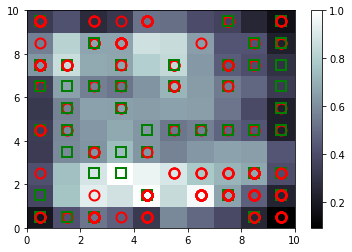

In [15]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show, save
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()


In [17]:
# Finding the frauds
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(5,2)], mappings[(7,2)]), axis = 0)
frauds = sc.inverse_transform(frauds)



# Part 2 - Going from Unsupervised to Supervised Deep Learning

In [19]:

# Creating the matrix of features
customers = dataset.iloc[:, 1:].values

# Creating the dependent variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1
        
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)


# Now let's make the ANN!

In [21]:

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)


Using TensorFlow backend.


Epoch 1/2
690/690 [==============================] - 2s 3ms/step - loss: 0.4353 - acc: 0.9855
Epoch 2/2
690/690 [==============================] - 1s 1ms/step - loss: 0.1221 - acc: 0.9870


In [25]:
# Predicting the probabilities of frauds
y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
# sorting list by probabilities
y_pred = y_pred[y_pred[:, 1].argsort()]


In [27]:
df = pd.DataFrame(y_pred)
df.to_csv('predicted_sorted_list.csv')